In [47]:

from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [48]:
gdrive_url = '/content/gdrive/My Drive/Colab Notebooks/'

In [49]:
import pandas as pd
import numpy as np


df_scaled = pd.read_csv(gdrive_url + 'scaled.csv')
df_scaled.head()

,Unnamed: 0,시가,고가,저가,종가,거래량
0,0,0.813365,0.751388,0.797528,0.790698,0.173325
1,1,0.813365,0.748974,0.802787,0.797158,0.243939
2,2,0.778126,0.739319,0.783066,0.791990,0.304593
3,3,0.740277,0.693459,0.744938,0.744186,0.132380
4,4,0.744192,0.688631,0.746253,0.731266,0.112340


In [50]:
TEST_SIZE = 200

In [51]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [52]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [53]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

In [54]:
train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

In [55]:
# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

In [56]:
# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [57]:
x_train.shape, x_valid.shape
# ((2108, 20, 4), (528, 20, 4))

((2108, 20, 4), (528, 20, 4))

In [58]:
# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 4), (180, 1))

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [60]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = gdrive_url + 'tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])


Epoch 1/200
132/132 [==============================] - ETA: 0s - loss: 0.0432
Epoch 00001: val_loss improved from inf to 0.00367, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
132/132 [==============================] - 3s 12ms/step - loss: 0.0432 - val_loss: 0.0037
Epoch 2/200
131/132 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00002: val_loss improved from 0.00367 to 0.00180, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
132/132 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 3/200
131/132 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00003: val_loss improved from 0.00180 to 0.00060, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
132/132 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 5.9737e-04
Epoch 4/200
128/132 [============================>.] - ETA: 0s - loss: 4.5443e-04
Epoch 00004: val_loss i

In [61]:
# weight 로딩
model.load_weights(filename)

In [62]:
# 예측
pred = model.predict(test_feature)

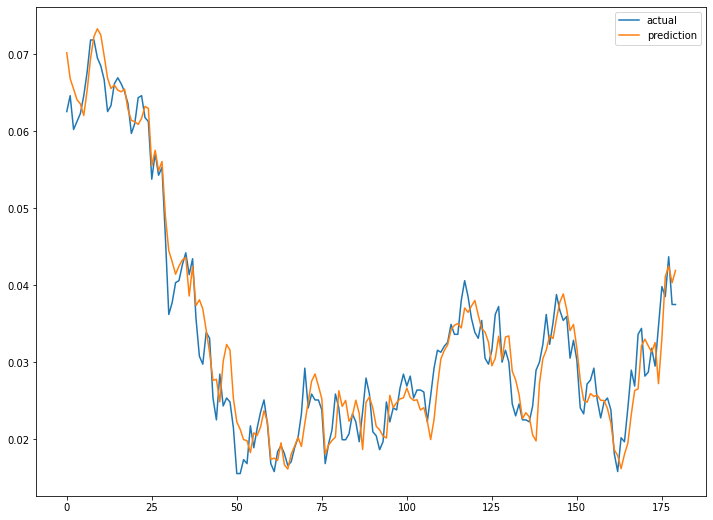

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()